In [1]:
from pymo.parsers import BVHParser

parser = BVHParser()
#fbs  = 60
parsed_data = parser.parse('/home/ltdoanh/ldtan/Motion_Diffusion/datasets/BEAT/beat_english_v0.2.1/beat_english_v0.2.1/1/1_wayne_0_1_1.bvh')

In [ ]:
from pymo.viz_tools import *

print_skel(parsed_data)

In [ ]:

from pymo.preprocessing import *
from sklearn.pipeline import Pipeline

data_pipe = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

piped_data = data_pipe.fit_transform([parsed_data])

In [12]:
print(piped_data.shape) 

(1, 4140, 264)


In [18]:
split_data = np.split(piped_data, 2, axis=1)

In [ ]:
spl

In [15]:
import os  
import numpy as np  
from textgrid import TextGrid  
  
def time_to_frame(t, fps=60):  
    return int(round(t * fps))  
  
def extract_sentences_with_text(  
    textgrid_path, text_path, motion_data, output_dir, fps=30, pause_threshold=0.5,   
    split_parts=2, use_first_part_only=True  
):  
    basename = os.path.splitext(os.path.basename(textgrid_path))[0]  
      
    # Áp dụng cách tách frames như trong PyMO pipeline  
    if motion_data.ndim == 3:  # Shape: (1, frames, features)  
        # Split dữ liệu theo axis=1 (features)  
        split_data = np.split(motion_data, split_parts, axis=1)  
          
        if use_first_part_only:  
            # Lấy phần đầu tiên và reshape từ 3D về 2D  
            motion = split_data[0].squeeze(0)  # Shape: (frames, features/2)  
        else:  
            # Reshape tất cả các phần  
            reshaped_data = [data.squeeze(0) for data in split_data]  
            motion = reshaped_data[0]  # Sử dụng phần đầu tiên  
    else:  
        # Nếu đã là 2D, sử dụng trực tiếp  
        motion = motion_data[0] if motion_data.ndim == 2 else motion_data  
      
    max_frames = motion.shape[0]  
      
    tg = TextGrid.fromFile(textgrid_path)  
    tier = tg[0]  
  
    # with open(text_path, 'r') as f:  
    #     full_text = f.read().strip()  
  
    os.makedirs(output_dir, exist_ok=True)  
  
    sentence_start = None  
    sentence_end = None  
    sentence_text = []  
    sentence_idx = 0  
      
    def save_sentence():  
        nonlocal sentence_idx, sentence_start, sentence_end, sentence_text  
          
        if not sentence_text or sentence_start is None or sentence_end is None:  
            return  
              
        start_frame = time_to_frame(sentence_start, fps)  
        end_frame = time_to_frame(sentence_end, fps)  
          
        # Đảm bảo không vượt quá bounds của motion data  
        start_frame = max(0, start_frame)  
        end_frame = min(max_frames, end_frame)  
          
        if end_frame <= start_frame:  
            print(f"⚠️ Skipped sentence {sentence_idx}: invalid frame range [{start_frame}, {end_frame}]")  
            return  
              
        motion_segment = motion[start_frame:end_frame, :]  
          
        fname_base = f"{basename}_sentence_{sentence_idx:03d}"  
        np.save(os.path.join(output_dir, fname_base + ".npy"), motion_segment)  
          
        with open(os.path.join(output_dir, fname_base + ".txt"), 'w') as ftxt:  
            ftxt.write(" ".join(sentence_text))  
          
        print(f"✅ Saved: {fname_base}.npy & .txt (frames: {start_frame}-{end_frame}, shape: {motion_segment.shape})")  
        sentence_idx += 1  
  
    # Xử lý TextGrid intervals  
    for interval in tier.intervals:  
        word = interval.mark.strip()  
        xmin = float(interval.minTime)  
        xmax = float(interval.maxTime)  
  
        if word != "":  
            if sentence_start is None:  
                sentence_start = xmin  
            sentence_end = xmax  
            sentence_text.append(word)  
        else:  
            pause_duration = xmax - xmin  
            if pause_duration >= pause_threshold and sentence_text:  
                save_sentence()  
                  
                # Reset cho câu tiếp theo  
                sentence_start = None  
                sentence_end = None  
                sentence_text = []  
  
    # Lưu câu cuối cùng  
    if sentence_text:  
        save_sentence()  
  
    print(f"🎉 Extracted {sentence_idx} sentences from {basename}")

In [16]:
extract_sentences_with_text(textgrid_path='/home/ltdoanh/ldtan/Motion_Diffusion/datasets/BEAT/beat_english_v0.2.1/beat_english_v0.2.1/1/1_wayne_0_1_1.TextGrid',
                            text_path="./text.txt",
                            motion_data = piped_data,
                            output_dir = "./",
                            )

✅ Saved: 1_wayne_0_1_1_sentence_000.npy & .txt (frames: 40-204, shape: (164, 264))
✅ Saved: 1_wayne_0_1_1_sentence_001.npy & .txt (frames: 221-389, shape: (168, 264))
✅ Saved: 1_wayne_0_1_1_sentence_002.npy & .txt (frames: 408-520, shape: (112, 264))
✅ Saved: 1_wayne_0_1_1_sentence_003.npy & .txt (frames: 544-694, shape: (150, 264))
✅ Saved: 1_wayne_0_1_1_sentence_004.npy & .txt (frames: 718-879, shape: (161, 264))
✅ Saved: 1_wayne_0_1_1_sentence_005.npy & .txt (frames: 896-1176, shape: (280, 264))
✅ Saved: 1_wayne_0_1_1_sentence_006.npy & .txt (frames: 1194-1247, shape: (53, 264))
✅ Saved: 1_wayne_0_1_1_sentence_007.npy & .txt (frames: 1282-1479, shape: (197, 264))
✅ Saved: 1_wayne_0_1_1_sentence_008.npy & .txt (frames: 1500-1774, shape: (274, 264))
✅ Saved: 1_wayne_0_1_1_sentence_009.npy & .txt (frames: 1791-1866, shape: (75, 264))
✅ Saved: 1_wayne_0_1_1_sentence_010.npy & .txt (frames: 1887-2018, shape: (131, 264))
🎉 Extracted 11 sentences from 1_wayne_0_1_1


In [ ]:
import os
import numpy as np
from pymo.parsers import BVHParser
from pymo.preprocessing import *
from sklearn.pipeline import Pipeline
data_dir = "/home/ltdoanh/ldtan/Motion_Diffusion/datasets/BEAT_numpy"
base_dir = "/home/ltdoanh/ldtan/Motion_Diffusion/datasets/BEAT/beat_english_v0.2.1/beat_english_v0.2.1/1"
npy_out_dir = os.path.join(data_dir , "npy_segments")
txt_out_dir = os.path.join(data_dir, "txt_segments")
os.makedirs(npy_out_dir, exist_ok=True)
os.makedirs(txt_out_dir, exist_ok=True)

parser = BVHParser()

data_pipe = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

for fname in os.listdir(base_dir):
    if fname.endswith(".bvh"):
        basename = fname.replace(".bvh", "")
        bvh_path = os.path.join(base_dir, fname)
        textgrid_path = os.path.join(base_dir, basename + ".TextGrid")
        text_path = os.path.join(base_dir, basename + ".txt")
        if not os.path.exists(textgrid_path) or not os.path.exists(text_path):
            continue  # Bỏ qua nếu thiếu file

        # Parse BVH và chạy pipeline
        if not os.path.exists(textgrid_path) or not os.path.exists(text_path):
            continue  # Bỏ qua nếu thiếu file

        try:
            parsed_data = parser.parse(bvh_path)
        except Exception as e:
            print(f"❌ Lỗi khi parse {bvh_path}: {e}")
            continue
        piped_data = data_pipe.fit_transform([parsed_data])

        # Gọi hàm tách segment
        extract_sentences_with_text(
            textgrid_path=textgrid_path,
            text_path=text_path,
            motion_data=piped_data,
            output_dir=npy_out_dir,
            split_parts=2,
            use_first_part_only=True
        )

        # Di chuyển file .txt sang txt_out_dir
        for f in os.listdir(npy_out_dir):
            if f.endswith(".txt"):
                os.rename(os.path.join(npy_out_dir, f), os.path.join(txt_out_dir, f))

In [2]:
import os

def count_files(folder, ext=None):
    """
    Đếm số file trong folder. Nếu ext được cung cấp (ví dụ '.bvh'), chỉ đếm file có đuôi đó.
    """
    files = os.listdir(folder)
    if ext:
        files = [f for f in files if f.endswith(ext)]
    return len(files)

# Ví dụ:
folder_path = "/home/ltdoanh/ldtan/Motion_Diffusion/datasets/BEAT_numpy/npy_segments"
print("Tổng số file:", count_files(folder_path))

folder_path = "/home/ltdoanh/ldtan/Motion_Diffusion/datasets/BEAT_numpy/txt_segments"
print("Tổng số file:", count_files(folder_path))

Tổng số file: 955
Tổng số file: 955


In [ ]:
# Split dữ liệu  
split_data = np.split(piped_data, 2, axis=1)  
  
# Reshape từng phần từ 3D về 2D  
reshaped_data = [data.squeeze(0) for data in split_data]  # Loại bỏ dimension đầu tiên  
  
# Hoặc nếu bạn chỉ muốn lấy phần đầu tiên:  
first_part = split_data[0].squeeze(0)  # Shape: (2070, 264)  
  
# Inverse transform  
reconstructed_data = data_pipe.inverse_transform([first_part])  
  
# Visualize  
draw_stickfigure(reconstructed_data[0], frame=130)

In [ ]:
pipe_data = np.load('/home/ltdoanh/ldtan/Motion_Diffusion/checkpoints/motion.npy')
reconstructed_data = data_pipe.inverse_transform([pipe_data])  
from pymo.viz_tools import draw_stickfigure
# Sau đó có thể visualize  
draw_stickfigure(reconstructed_data[0], frame=1)

In [ ]:
mp = MocapParameterizer('position')

positions = mp.fit_transform([parsed_data])

In [6]:
positions[0]

<AxesSubplot:>

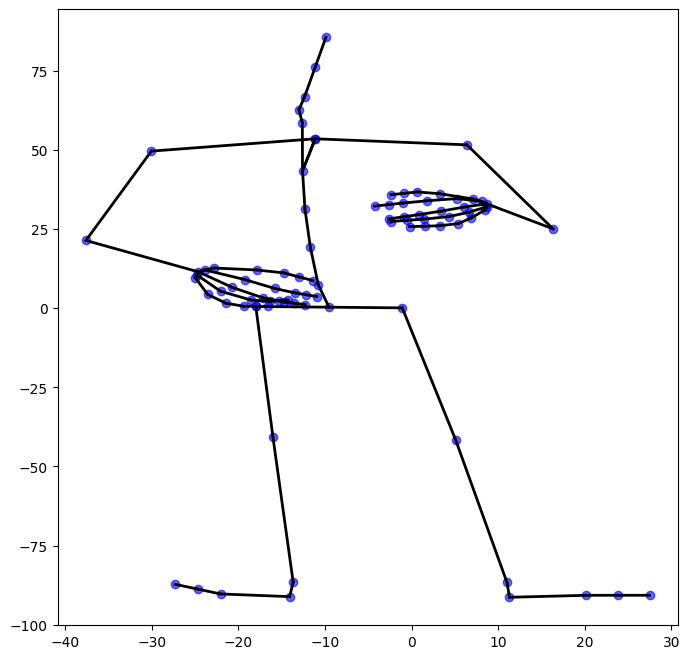

In [10]:
from pymo.viz_tools import draw_stickfigure
draw_stickfigure(positions[0], frame=130)

In [ ]:
from pymo.preprocessing import *  
from sklearn.pipeline import Pipeline  
  
# Tạo pipeline với Numpyfier ở cuối  
data_pipe = Pipeline([  
    ('param', MocapParameterizer('position')),  
    ('rcpn', RootCentricPositionNormalizer()),  
    ('delta', RootTransformer('abdolute_translation_deltas')),  
    ('const', ConstantsRemover()),  
    ('np', Numpyfier()),  # Chuyển đổi sang numpy array  
    ('down', DownSampler(2)),  
    ('stdscale', ListStandardScaler())  
])  
  
# Áp dụng pipeline  
piped_data = data_pipe.fit_transform([parsed_data])  
  
# Xem shape  
print(piped_data.shape) 

In [ ]:
import os
import numpy as np
from textgrid import TextGrid

def time_to_frame(t, fps=60):
    return int(round(t * fps))

def extract_sentences_with_text(
    textgrid_path, text_path, motion_data, output_dir, fps=60, pause_threshold=0.5
):
    basename = os.path.splitext(os.path.basename(textgrid_path))[0]  # ví dụ: 1_wayne_0_1_1
    motion = motion_data[0]  # shape: (num_frames, 264)

    tg = TextGrid.fromFile(textgrid_path)
    tier = tg[0]  # chỉ lấy item[1]

    with open(text_path, 'r') as f:
        full_text = f.read().strip()

    os.makedirs(output_dir, exist_ok=True)

    sentence_start = None
    sentence_end = None
    sentence_text = []
    sentence_idx = 0

    for interval in tier.intervals:
        word = interval.mark.strip()
        xmin = float(interval.minTime)
        xmax = float(interval.maxTime)

        if word != "":
            if sentence_start is None:
                sentence_start = xmin
            sentence_end = xmax
            sentence_text.append(word)
        else:
            pause = xmax - xmin
            if pause >= pause_threshold and sentence_text:
                # Save motion
                start_frame = time_to_frame(sentence_start, fps)
                end_frame = time_to_frame(sentence_end, fps)
                motion_segment = motion[start_frame:end_frame, :]

                fname_base = f"{basename}_sentence_{sentence_idx:03d}"
                np.save(os.path.join(output_dir, fname_base + ".npy"), motion_segment)

                # Save sentence text
                with open(os.path.join(output_dir, fname_base + ".txt"), 'w') as ftxt:
                    ftxt.write(" ".join(sentence_text))

                print(f"✅ Saved: {fname_base}.npy & .txt")

                sentence_idx += 1
                sentence_start = None
                sentence_end = None
                sentence_text = []

    # Save câu cuối cùng nếu còn
    if sentence_text:
        start_frame = time_to_frame(sentence_start, fps)
        end_frame = time_to_frame(sentence_end, fps)
        motion_segment = motion[start_frame:end_frame, :]

        fname_base = f"{basename}_sentence_{sentence_idx:03d}"
        np.save(os.path.join(output_dir, fname_base + ".npy"), motion_segment)
        with open(os.path.join(output_dir, fname_base + ".txt"), 'w') as ftxt:
            ftxt.write(" ".join(sentence_text))
        print(f"✅ Saved: {fname_base}.npy & .txt")



✅ Saved: 000_sentence.npy (81–407)
✅ Saved: 001_sentence.npy (442–779)
✅ Saved: 002_sentence.npy (815–1041)
✅ Saved: 003_sentence.npy (1089–1387)
✅ Saved: 004_sentence.npy (1436–1759)
✅ Saved: 005_sentence.npy (1792–2351)
✅ Saved: 006_sentence.npy (2389–2495)
✅ Saved: 007_sentence.npy (2564–2959)
✅ Saved: 008_sentence.npy (3000–3547)
✅ Saved: 009_sentence.npy (3582–3732)
✅ Saved: 010_sentence.npy (3775–4036)


In [3]:
import os

# Thư mục chứa các segment (npy hoặc txt)
segment_dir = "/home/ltdoanh/ldtan/Motion_Diffusion/datasets/beat2motion_dataset/npy_segments"  # sửa lại cho đúng đường dẫn của bạn
output_txt = "/home/ltdoanh/ldtan/Motion_Diffusion/datasets/beat2motion_dataset/train.txt"      # nơi lưu file train.txt

clip_ids = []
for fname in os.listdir(segment_dir):
    if fname.endswith(".npy"):  # hoặc ".txt" nếu muốn lấy theo file text
        clip_id = os.path.splitext(fname)[0]
        clip_ids.append(clip_id)

clip_ids = sorted(set(clip_ids))  # loại trùng và sắp xếp

with open(output_txt, "w", encoding="utf-8") as f:
    for cid in clip_ids:
        f.write(cid + "\n")

print(f"Đã tạo {output_txt} với {len(clip_ids)} clip id.")

Đã tạo /home/ltdoanh/ldtan/Motion_Diffusion/datasets/beat2motion_dataset/train.txt với 955 clip id.
